In [1]:
import awkward as ak
from coffea import hist, processor
from coffea.nanoevents import BaseSchema
import numpy as np
import math
%matplotlib inline

In [18]:
fileset = {'Data': ['4lep/Data/data_A.4lep.root',
                    '4lep/Data/data_B.4lep.root',
                    '4lep/Data/data_C.4lep.root',
                    '4lep/Data/data_D.4lep.root'],
           'Background $Z,t\bar{t}$': ['4lep/MC/mc_361106.Zee.4lep.root',
                                       '4lep/MC/mc_361107.Zmumu.4lep.root',
                                       '4lep/MC/mc_410000.ttbar_lep.4lep.root'],
           'Background $ZZ^{star}$': ['4lep/MC/mc_363490.llll.4lep.root'],
           'Signal ($m_H$ = 125 GeV)': ['4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root',
                                        '4lep/MC/mc_344235.VBFH125_ZZ4lep.4lep.root',
                                        '4lep/MC/mc_341964.WH125_ZZ4lep.4lep.root',
                                        '4lep/MC/mc_341947.ZH125_ZZ4lep.4lep.root']}

In [4]:
# Method from 

def calc_mllll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lep[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lep[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lep[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lep[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lep[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lep[1] momentum
    px_2 = lep_pt[2]*math.cos(lep_phi[2]) # x-component of lep[2] momentum
    py_2 = lep_pt[2]*math.sin(lep_phi[2]) # y-component of lep[2] momentum
    pz_2 = lep_pt[2]*math.sinh(lep_eta[2]) # z-component of lep[3] momentum
    px_3 = lep_pt[3]*math.cos(lep_phi[3]) # x-component of lep[3] momentum
    py_3 = lep_pt[3]*math.sin(lep_phi[3]) # y-component of lep[3] momentum
    pz_3 = lep_pt[3]*math.sinh(lep_eta[3]) # z-component of lep[3] momentum
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of 4-lepton momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of 4-lepton momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of 4-lepton momentum
    sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] # energy of 4-lepton system
    return math.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)/1000 #/1000 to go from MeV to GeV

In [5]:
# Methods from 

# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)

In [15]:
class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        mllll_axis = hist.Bin("mllll", "4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]", 34, 80, 250)
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "mllll": hist.Hist("Events / 5 GeV", dataset_axis, mllll_axis)
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata["dataset"]
        
        """
        # I thought maybe I needed to use this? But this doesn't seem to change the structure of the data at all
        leptons = ak.zip({
            "charge": events.lep_charge,
            "type": events.lep_type,
            "pt": events.lep_pt,
            "eta": events.lep_eta,
            "phi": events.lep_phi,
            "E": events.lep_E
        })
        """
        """
        # This doesn't work because the function indexes into events when it should index into the particle in an individual event
        charge_cut = cut_lep_charge(events.lep_charge)
        events = events[~charge_cut]
        type_cut = cut_lep_type(events.lep_type)
        events = events[~type_cut]
        mllll = calc_mllll(events.lep_pt, events.lep_eta, events.lep_phi, events.lep_E)
        """
        events = [event for event in events if not cut_lep_charge(event.lep_charge)]
        events = [event for event in events if not cut_lep_type(event.lep_type)]
        mllll = np.array([calc_mllll(event.lep_pt, event.lep_eta, event.lep_phi, event.lep_E) for event in events])
        
        output["sumw"][dataset] += len(events)
        output["mllll"].fill(dataset=dataset, mllll=mllll)

        return output

    def postprocess(self, accumulator):
        return accumulator

In [19]:
from dask.distributed import Client
import time

client = Client()

output = processor.run_uproot_job(fileset,
                                treename = 'mini',
                                processor_instance = Processor(),
                                executor = processor.dask_executor,
                                executor_args = {'schema': BaseSchema, 'client': client}
                                )

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP st

[                                        ] | 0% Completed |  1.0s

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


<AxesSubplot:xlabel='4-lepton invariant mass $\\mathrm{m_{4l}}$ [GeV]', ylabel='Events / 5 GeV'>

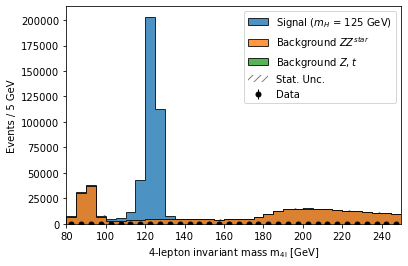

In [23]:
import re

notdata = re.compile('(?!Data)')

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label': 'Stat. Unc.',
    'hatch': '///',
    'facecolor': 'none',
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,
}

hist.plot1d(output['mllll'][notdata], overlay='dataset', stack=True, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['mllll']['Data'], overlay='dataset', clear=False, error_opts=data_err_opts)

In [24]:
"""
# Just for testing/exploring the events data structure
from coffea.nanoevents import NanoEventsFactory

fname = '4lep/MC/mc_361107.Zmumu.4lep.root'
events = NanoEventsFactory.from_root(fname, schemaclass=BaseSchema, treepath='mini').events()
"""